# Paleobiology dataset
Source: https://paleobiodb.org/#/

For my dataset, I chose to download the specimen and measurements of occurrences found in Europe. I am going to look into the average measurements of specimens, maybe see if larger specimens are more common or smaller specimens. 

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [317]:
measure = pd.read_csv("measurement.csv", decimal=',')
specimen = pd.read_csv("specimen.csv", decimal=',')

/var/folders/7y/ppl4dg_n3_9fbc0v0tc07f4r0000gn/T/ipykernel_1776/3869381938.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  measure = pd.read_csv("measurement.csv", decimal=',')
/var/folders/7y/ppl4dg_n3_9fbc0v0tc07f4r0000gn/T/ipykernel_1776/3869381938.py:2: DtypeWarning: Columns (2,14) have mixed types. Specify dtype option on import or set low_memory=False.
  specimen = pd.read_csv("specimen.csv", decimal=',')


In [318]:
all_data = measure.merge(specimen, on="specimen_no", how="inner")

In [319]:
all_data.head()

,measurement_no,specimen_no,record_type_x,n_measured_x,position,measurement_type,average,min,max,record_type_y,...,identified_name,identified_rank,identified_no,difference,accepted_name,accepted_rank,accepted_no,max_ma,min_ma,reference_no
0,151,76,mea,33.0,NaN,length,29.42,NaN,NaN,spm,...,Alces alces,species,43850,NaN,Alces alces,species,45013.0,0.126,0.0117,8850
1,152,76,mea,33.0,NaN,width,20.48,NaN,NaN,spm,...,Alces alces,species,43850,NaN,Alces alces,species,45013.0,0.126,0.0117,8850
2,22020,10998,mea,1.0,NaN,diagonal,49.49,NaN,NaN,spm,...,Orthodesma,genus,16394,NaN,Orthodesma,genus,16394.0,457.5,455.8,6157
3,22021,10998,mea,1.0,NaN,length,65.54,NaN,NaN,spm,...,Orthodesma,genus,16394,NaN,Orthodesma,genus,16394.0,457.5,455.8,6157
4,22022,10998,mea,1.0,NaN,height,24.9,NaN,NaN,spm,...,Orthodesma,genus,16394,NaN,Orthodesma,genus,16394.0,457.5,455.8,6157


#### First of all, lets look at some basic info. I want to check the shape of my data and what is missing.

In [320]:
# Checking out shape and info on missing values

all_data.shape


(87381, 34)

In [321]:
pd.options.display.max_rows = 4000

In [322]:
# 87,381 rows and 34 columns

missing_values_count = all_data.isnull().sum()
missing_values_count

measurement_no            0
specimen_no               0
record_type_x             0
n_measured_x              5
position              84788
measurement_type          0
average                   0
min                   87381
max                   87381
record_type_y             0
flags                 87285
occurrence_no             0
reid_no                   0
collection_no             0
specimen_id           13180
is_type               57229
specelt_no            87381
specimen_side         79761
specimen_part          3776
specimen_sex          82969
n_measured_y              5
measurement_source     4767
magnification         82471
comments              84131
identified_name           0
identified_rank           5
identified_no             0
difference            70683
accepted_name            22
accepted_rank            22
accepted_no              22
max_ma                    0
min_ma                    0
reference_no              0
dtype: int64

I can see from this result that min and max are fully missing, position has most missing, as well as specimen_id, is_type, specelt_no etc. I think for the columns with that many missing, I'm going to drop them. 
But first I'm going to make a copy of my dataset incase I get this all wrong

In [323]:
data = all_data

In [324]:
data = data.drop(['position', 'min', 'max', 'flags', 'specimen_id', 'is_type', 'is_type', 'specelt_no', 'specimen_side', 'specimen_part', 'specimen_sex', 'measurement_source', 'magnification', 'comments', 'difference', 'reid_no', 'record_type_x'], axis=1)

Looking at the general info of the data

In [325]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87381 entries, 0 to 87380
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   measurement_no    87381 non-null  int64  
 1   specimen_no       87381 non-null  int64  
 2   n_measured_x      87376 non-null  float64
 3   measurement_type  87381 non-null  object 
 4   average           87381 non-null  object 
 5   record_type_y     87381 non-null  object 
 6   occurrence_no     87381 non-null  int64  
 7   collection_no     87381 non-null  int64  
 8   n_measured_y      87376 non-null  float64
 9   identified_name   87381 non-null  object 
 10  identified_rank   87376 non-null  object 
 11  identified_no     87381 non-null  int64  
 12  accepted_name     87359 non-null  object 
 13  accepted_rank     87359 non-null  object 
 14  accepted_no       87359 non-null  float64
 15  max_ma            87381 non-null  object 
 16  min_ma            87381 non-null  object

In [326]:
data.describe()

,measurement_no,specimen_no,n_measured_x,occurrence_no,collection_no,n_measured_y,identified_no,accepted_no,reference_no
count,87381.000000,87381.000000,87376.000000,8.738100e+04,87381.000000,87376.000000,87381.000000,87359.000000,87381.000000
mean,228636.331605,107498.317769,1.000961,1.084052e+06,128396.512114,1.000961,246518.719825,242074.969517,43139.673236
std,94810.021726,42902.548270,0.154658,2.256188e+05,35799.971304,0.154658,77496.978627,78179.325765,13539.940126
min,151.000000,76.000000,0.000000,2.565200e+04,1854.000000,0.000000,0.000000,1243.000000,262.000000
25%,169992.000000,77043.000000,1.000000,9.670200e+05,108672.000000,1.000000,191145.000000,184779.000000,35266.000000
50%,250571.000000,119068.000000,1.000000,1.136110e+06,124205.000000,1.000000,258782.000000,251836.000000,44589.000000
75%,307255.000000,143697.000000,1.000000,1.226548e+06,158200.000000,1.000000,301537.000000,300651.000000,52485.000000
max,357204.000000,162619.000000,33.000000,1.619856e+06,228970.000000,33.000000,467610.000000,467610.000000,83834.000000


In [327]:
data.columns

Index(['measurement_no', 'specimen_no', 'n_measured_x', 'measurement_type',
       'average', 'record_type_y', 'occurrence_no', 'collection_no',
       'n_measured_y', 'identified_name', 'identified_rank', 'identified_no',
       'accepted_name', 'accepted_rank', 'accepted_no', 'max_ma', 'min_ma',
       'reference_no'],
      dtype='object')

In [328]:
data.dtypes

measurement_no        int64
specimen_no           int64
n_measured_x        float64
measurement_type     object
average              object
record_type_y        object
occurrence_no         int64
collection_no         int64
n_measured_y        float64
identified_name      object
identified_rank      object
identified_no         int64
accepted_name        object
accepted_rank        object
accepted_no         float64
max_ma               object
min_ma               object
reference_no          int64
dtype: object

##### I have a lot of dtype = object, which I don't want, so I'm going to convert them. 

In [329]:
data["average"] = data["average"].str.replace(',','.')

In [330]:
data["average"] = data["average"].astype(float)



In [331]:
avg_measurement_by_spec = data.groupby("accepted_name")["average"].mean()
#How do I do it so I am also filtering the average of only measurements == length or measurements == width
#Do i one-hot encode?
avg_measurement_by_spec.head(15)

accepted_name
Aalenirhynchia subdecorata        22.588889
Aalenirhynchia walkeri            22.566667
Abaptilon sibiricum               28.250000
Abashevia suchovi                 18.750000
Abbasitoides modestus             20.625000
Abbrevikhosara ovoidea            11.150000
Abdera (Abdera) hoffeinsorum       1.950000
Abdera (Abdera) rikojotensis       2.325000
Abderina helmi                     3.500000
Abelater succineus                 1.950000
Aberrokorynetes abludens           3.200000
Aberrokorynetes oceanojubilaei     2.335000
Aboilus krassilovi                41.150000
Abraracourcix curvivenatus         6.650000
Abrekia sulcata                    5.539130
Name: average, dtype: float64

In [332]:
data.head()

,measurement_no,specimen_no,n_measured_x,measurement_type,average,record_type_y,occurrence_no,collection_no,n_measured_y,identified_name,identified_rank,identified_no,accepted_name,accepted_rank,accepted_no,max_ma,min_ma,reference_no
0,151,76,33.0,length,29.42,spm,443591,43689,33.0,Alces alces,species,43850,Alces alces,species,45013.0,0.126,0.0117,8850
1,152,76,33.0,width,20.48,spm,443591,43689,33.0,Alces alces,species,43850,Alces alces,species,45013.0,0.126,0.0117,8850
2,22020,10998,1.0,diagonal,49.49,spm,155413,13832,1.0,Orthodesma,genus,16394,Orthodesma,genus,16394.0,457.5,455.8,6157
3,22021,10998,1.0,length,65.54,spm,155413,13832,1.0,Orthodesma,genus,16394,Orthodesma,genus,16394.0,457.5,455.8,6157
4,22022,10998,1.0,height,24.90,spm,155413,13832,1.0,Orthodesma,genus,16394,Orthodesma,genus,16394.0,457.5,455.8,6157


In [333]:
avg_measurement_by_spec = data.groupby(["accepted_name", "measurement_type"])["average"].agg([min, max, np.mean])
avg_measurement_by_spec.head()


min   max       mean
accepted_name              measurement_type                       
Aalenirhynchia subdecorata height            20.1  22.1  21.200000
                           length            19.5  21.5  20.433333
                           width             24.4  27.5  26.133333
Aalenirhynchia walkeri     height            18.9  18.9  18.900000
                           length            22.5  22.5  22.500000

# My focus in this project is the distribution of the measurements of some of the fossil occurrences recorded. 

In [334]:
measured_data = pd.DataFrame(avg_measurement_by_spec)

In [335]:
measured_data = measured_data.reset_index(level="measurement_type")

In [336]:
pivot = measured_data.pivot_table(values="mean", index="accepted_name", columns="measurement_type", fill_value=0)

#### Below is my table I'm working with. I have all of the measurements of the fossils. Lets look at the longest and shortest ones!

In [337]:
pivot

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Aalenirhynchia subdecorata,0.0,0.0,0.0,21.2,0.0,20.433333,26.133333
Aalenirhynchia walkeri,0.0,0.0,0.0,18.9,0.0,22.500000,26.300000
Abaptilon sibiricum,0.0,0.0,0.0,0.0,0.0,40.000000,16.500000
Abashevia suchovi,0.0,0.0,0.0,0.0,0.0,27.000000,10.500000
Abbasitoides modestus,0.0,0.0,39.0,13.0,17.5,0.000000,13.000000
...,...,...,...,...,...,...,...
Zygopleura walmstedti,0.0,0.0,0.0,19.4,0.0,0.000000,8.066667
Zygoptera,0.0,0.0,0.0,0.0,0.0,62.500000,0.000000
Zygospira,0.0,0.0,0.0,0.0,0.0,21.490000,24.390000


In [338]:
pivot.sort_values(by = 'length', ascending=False)

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Balaenoptera (Plesiocetus) cortesii,0.0,0.0,0.000000,0.0000,0.000000,1980.0,750.000000
Lusotitan atalaiensis,1100.0,0.0,0.000000,0.0000,0.000000,1525.0,0.000000
Zygophyseter varolai,0.0,0.0,0.000000,0.0000,0.000000,1480.0,745.000000
Titanocetus sammarinensis,0.0,0.0,0.000000,0.0000,0.000000,1330.0,720.000000
Aragosaurus ischiaticus,0.0,0.0,0.000000,0.0000,0.000000,1310.0,332.500000
...,...,...,...,...,...,...,...
Asteroceras reynesi,0.0,0.0,45.350000,0.0000,0.000000,0.0,16.335000
Praewerneroceras suchomastense,0.0,0.0,30.687500,13.8125,7.812500,0.0,16.875000
Praesibirites tuberculatus,0.0,0.0,39.733333,10.9000,19.933333,0.0,8.566667


In [339]:
pivot.sort_values(by = 'width', ascending=False)

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Balaenoptera (Plesiocetus) cortesii,0.0,0.0,0.0,0.0,0.0,1980.000,750.0
Zygophyseter varolai,0.0,0.0,0.0,0.0,0.0,1480.000,745.0
Uranocetus gramensis,0.0,0.0,0.0,0.0,0.0,606.750,736.0
Titanocetus sammarinensis,0.0,0.0,0.0,0.0,0.0,1330.000,720.0
Pinocetus polonicus,0.0,0.0,0.0,0.0,0.0,897.500,706.0
...,...,...,...,...,...,...,...
Psiloptera incerta,0.0,0.0,0.0,0.0,0.0,13.000,0.0
Mordellistena soror,0.0,0.0,0.0,0.0,0.0,3.400,0.0
Cinetus elongatus,0.0,0.0,0.0,0.0,0.0,4.175,0.0


### The longest and widest fossil record is the 'Balaenoptera cortesi'...

The Plesiocetus were a genus of extinct balaenopterids. These were a type of whale. Some of the extant (current) species within this genus are the Minke's whale, fin whale, blue whale and Omura's whale. 

They would have looked similar to this: 

![balaenoptera_whale](balae_whale.jpeg)

###### image source: [wikiwand](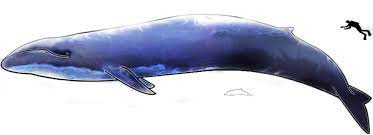)

### Now lets look at the tallest fossil record.. the Pachydesmoceras pachydiscoide

In [340]:
pivot.sort_values(by = 'height', ascending=False)

measurement_type,circumference,diagonal,diameter,height,inflation,length,width
accepted_name,,,,,,,
Pachydesmoceras pachydiscoide,0.0,0.0,1080.00,420.500000,322.5,0.00,293.50
Parapuzosia (Parapuzosia) seppenradensis,0.0,0.0,1280.25,370.166667,396.0,0.00,476.00
Pustulifer alpina,0.0,0.0,0.00,300.000000,0.0,0.00,102.00
Pinacoceras parma,0.0,0.0,512.50,282.500000,47.5,0.00,66.00
Pinacoceras metternichi,0.0,0.0,495.00,275.000000,43.0,0.00,71.00
...,...,...,...,...,...,...,...
Mastotermes nepropadyom,0.0,0.0,0.00,0.000000,0.0,10.00,0.00
Mastotermes picardi,0.0,0.0,0.00,0.000000,0.0,19.65,8.50
Mastotermes sarthensis,0.0,0.0,0.00,0.000000,0.0,7.00,0.00


These are a genus of ammonites. They were actually carnivorous, and lived during the cretaceous period. Here is a fossil from a museum in Japan: 

![pachydemoceras](Pachydesmoceras_pachydiscoide.jpg)

###### image source: [wikipedia](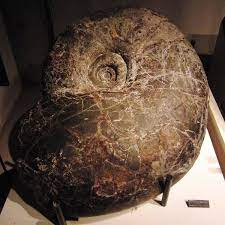)

 They don't look too scary like this, but if you saw one swimming... 

 ![pachydesmoceras](ammonite-swimming.jpg)

 ###### image source [pachydesmoceras](https://www.google.co.uk/url?sa=i&url=https%3A%2F%2Fammonite360.wordpress.com%2F2016%2F03%2F27%2Flocomotion%2F&psig=AOvVaw2gxWLo1iz0mTldOsYdenqM&ust=1676659316415000&source=images&cd=vfe&ved=0CA8QjRxqFwoTCJirv-nYmv0CFQAAAAAdAAAAABAK)

In [341]:
measured_data[measured_data["measurement_type"] == "length"]

,measurement_type,min,max,mean
accepted_name,,,,
Aalenirhynchia subdecorata,length,19.50,21.50,20.433333
Aalenirhynchia walkeri,length,22.50,22.50,22.500000
Abaptilon sibiricum,length,40.00,40.00,40.000000
Abashevia suchovi,length,27.00,27.00,27.000000
Abbrevikhosara ovoidea,length,15.00,15.00,15.000000
...,...,...,...,...
Zygophyseter varolai,length,1480.00,1480.00,1480.000000
Zygoptera,length,60.00,65.00,62.500000
Zygospira,length,21.49,21.49,21.490000


In [342]:
measured_data[measured_data["measurement_type"] == "width"]

,measurement_type,min,max,mean
accepted_name,,,,
Aalenirhynchia subdecorata,width,24.40,27.50,26.133333
Aalenirhynchia walkeri,width,26.30,26.30,26.300000
Abaptilon sibiricum,width,16.50,16.50,16.500000
Abashevia suchovi,width,10.50,10.50,10.500000
Abbasitoides modestus,width,12.00,14.00,13.000000
...,...,...,...,...
Zygopleura arctecostata,width,3.10,10.40,5.840000
Zygopleura hybrida,width,5.20,5.90,5.600000
Zygopleura walmstedti,width,7.60,8.60,8.066667


In [343]:
length_mean = measured_data[measured_data["measurement_type"] == "length"]
length_mean

,measurement_type,min,max,mean
accepted_name,,,,
Aalenirhynchia subdecorata,length,19.50,21.50,20.433333
Aalenirhynchia walkeri,length,22.50,22.50,22.500000
Abaptilon sibiricum,length,40.00,40.00,40.000000
Abashevia suchovi,length,27.00,27.00,27.000000
Abbrevikhosara ovoidea,length,15.00,15.00,15.000000
...,...,...,...,...
Zygophyseter varolai,length,1480.00,1480.00,1480.000000
Zygoptera,length,60.00,65.00,62.500000
Zygospira,length,21.49,21.49,21.490000


In [344]:
width_mean = measured_data[measured_data["measurement_type"] == "width"]
width_mean

,measurement_type,min,max,mean
accepted_name,,,,
Aalenirhynchia subdecorata,width,24.40,27.50,26.133333
Aalenirhynchia walkeri,width,26.30,26.30,26.300000
Abaptilon sibiricum,width,16.50,16.50,16.500000
Abashevia suchovi,width,10.50,10.50,10.500000
Abbasitoides modestus,width,12.00,14.00,13.000000
...,...,...,...,...
Zygopleura arctecostata,width,3.10,10.40,5.840000
Zygopleura hybrida,width,5.20,5.90,5.600000
Zygopleura walmstedti,width,7.60,8.60,8.066667


In [345]:
measured_data.head()
y = pd.get_dummies(measured_data.measurement_type, prefix = "measure")
y.head()
data = measured_data.merge(y, on="accepted_name", how = "inner")

In [346]:
data.head()
data.drop("measurement_type", axis=1)

,min,max,mean,measure_circumference,measure_diagonal,measure_diameter,measure_height,measure_inflation,measure_length,measure_width
accepted_name,,,,,,,,,,
Aalenirhynchia subdecorata,20.10,22.10,21.200000,0,0,0,1,0,0,0
Aalenirhynchia subdecorata,20.10,22.10,21.200000,0,0,0,0,0,1,0
Aalenirhynchia subdecorata,20.10,22.10,21.200000,0,0,0,0,0,0,1
Aalenirhynchia subdecorata,19.50,21.50,20.433333,0,0,0,1,0,0,0
Aalenirhynchia subdecorata,19.50,21.50,20.433333,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
Zygota filicornis,2.00,2.30,2.150000,0,0,0,0,0,1,0
Zymus succinicola,1.00,1.00,1.000000,0,0,0,0,0,1,0
Zymus succinicola,1.00,1.00,1.000000,0,0,0,0,0,0,1


In [347]:
from sklearn.cluster import KMeans